## Multi-classification problem

__Note:__ you might need to do
`conda install torchvision "pillow<7"`
if torchvision is not already installed on your computer, and/or for compatibility issues (the version of torchvision version supporting the last version of Pillow is not released yet).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import requests
import os


import matplotlib.pyplot as plt

%matplotlib inline

## Load Data

PyTorch provides two powerful data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as prepare your own data. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples.

### USPS Dataset
* Handwritten digits with 10 classes
* 16x16 pixels for each image 
* 6 000 data examples in training set, 1 291 examples in validation set, 2 007 in test set

In [2]:
url = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.bz2'
r = requests.get(url, allow_redirects=True)
if not os.path.isdir('USPS/'):
    os.mkdir('USPS/')
open('USPS/usps.bz2', 'wb').write(r.content)

6579383

In [3]:
# Loading USPS dataset from torchvision.dataset
dataset = torchvision.datasets.USPS(root='USPS/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=False)

In [4]:
# Get info from dataset
dataset

Dataset USPS
    Number of datapoints: 7291
    Root location: USPS/
    StandardTransform
Transform: ToTensor()

In [5]:
# Obtain the inputs and targets:
inputs = dataset.data
targets = dataset.targets

In [6]:
# split the dataset to training and validation sets
train_set, val_set = random_split(dataset, [6000, 1291])

Text(0.5, 1.0, 'image label: 9')

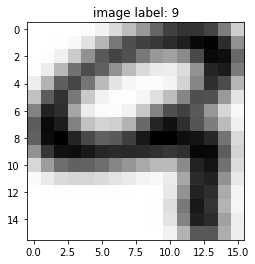

In [7]:
sample_index = 88
plt.imshow(dataset.data[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("image label: %d" % dataset.targets[sample_index])

## Build your Neural Network
The `torch.nn` namespace provides all the building blocks you need to create your own neural network such as fully connected layers or convolutional layers etc. We define our neural network by subclassing `nn.Module`, and the neural network layers are initialized in **\__init\__**. Every `nn.Module` subclass implements the operations on input data in the **forward** method.

In [8]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.l1 = nn.Linear(16*16, 100)
        self.l2 = nn.Linear(100, 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs):
        h = F.relu(self.l1(inputs))
        outputs = F.softmax(self.l2(h), dim=1)# Use softmax as the activation function for the last layer
        return outputs

## Train your Model

In [9]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.1
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [10]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            y_pre = model(images.view(batch_size, -1)) 
            #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [11]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

Epoch [1/10], Loss: 0.0863
Epoch [2/10], Loss: 0.0722
Epoch [3/10], Loss: 0.0591
Epoch [4/10], Loss: 0.0463
Epoch [5/10], Loss: 0.0351
Epoch [6/10], Loss: 0.0264
Epoch [7/10], Loss: 0.0209
Epoch [8/10], Loss: 0.0176
Epoch [9/10], Loss: 0.0155
Epoch [10/10], Loss: 0.0141


Text(0.5, 1.0, 'Visualization of convergence')

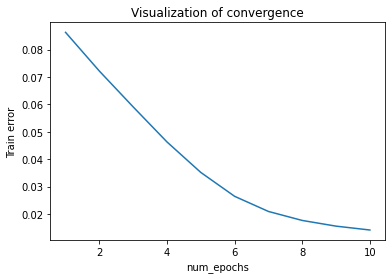

In [12]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

### Evaluate the Model on validation set

In [13]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            images = images.view(-1, 16*16)
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1) 
            
            correct += (predicted == labels).sum()

    print('Accuracy of the model : {:.2f} %'.format(100*correct.item() / len(dataset)))

In [14]:
accuracy(val_set, model)

Accuracy of the model : 93.57 %


Text(0.5, 1.0, 'Prediction label: 2')

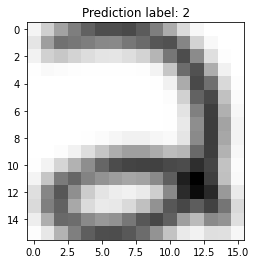

In [15]:
val_index = 66

(image, label) = val_set[val_index]
output = model(image.view(-1, 16*16))
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.

#### Define a CNN

In [99]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 30, 4)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(30, 150, 4)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.act2 = nn.ReLU()

        self.dropout = nn.Dropout(p = 0.01)
        
        
        self.fc1 = nn.Linear(150, 16)
        self.fc2 = nn.Linear(16, 10)
        
        self.output = nn.Softmax(dim=1)
     
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.pool2(x)
        x = self.act2(x)

        x = torch.flatten(x, 1)
    
        x = self.fc1(x)
        x = self.fc2(x)

        output = self.output(x)
        
        return output

#### Train the model

In [100]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 30
batch_size = 10

# Use mean squared loss function 
criterion = nn.MSELoss()

#criterion = nn.CrossEntropyLoss()

# Use SGD optimizer with a learning rate of 0.1
# It is initialized on our model

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [101]:
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    
    for epoch in range(num_epochs):
        
        epoch_average_loss = 0.0
        
        for (images, labels) in train_loader:
            
            y_pre = model(images) 
            #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
            
    
           
            loss = criterion(y_pre, labels_one_hot)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            epoch_average_loss += loss.item() * batch_size / len(dataset)
            
        train_error.append(epoch_average_loss)
        #print('Epoch [{}/{}], Loss: {:.4f}'
                      #.format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

Text(0.5, 1.0, 'Visualization of convergence')

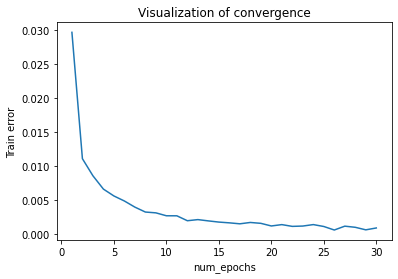

In [102]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

#### Evaluate model performance in validation dataset

In [90]:
def accuracy(dataset, model):

    with torch.no_grad():
        
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        
        for (images, labels) in dataloader:
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1) 
            
            correct += (predicted == labels).sum()
    
    #print('Accuracy of the model in Validation set : {:.2f} %'.format(100*correct.item()/ len(dataset)))
    return 100*correct.item() / len(dataset)
    

In [91]:
accuracy(val_set, model)

97.52130131680867

### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

#### Try different batch size

In [22]:
batch_size_set = [5,10,15,20,25,30,50,100,200,300,400,1000]
val_accu_set = []

In [94]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 30, 4)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(30, 150, 4)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.act2 = nn.ReLU()

        self.dropout = nn.Dropout(p = 0.01)
        
        
        self.fc1 = nn.Linear(150, 16)
        self.fc2 = nn.Linear(16, 10)
        
        self.output = nn.Softmax(dim=1)
     
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.pool2(x)
        x = self.act2(x)

        x = torch.flatten(x, 1)
    
        x = self.fc1(x)
        x = self.fc2(x)

        output = self.output(x)
        
        return output

In [95]:
for batch_size in batch_size_set:
  
  model = Model()
  
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  criterion = nn.MSELoss()

  train(10, batch_size, criterion, optimizer, model, train_set)
  val_accu = accuracy(val_set, model)
  val_accu_set.append(val_accu)
  print("Current batch size is: ", batch_size, "; Validation loss is ", val_accu)

RuntimeError: ignored

In [63]:
for batch_size in batch_size_set:
  
  model = Model()
  
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  criterion = nn.CrossEntropyLoss()

  train(10, batch_size, criterion, optimizer, model, train_set)
  val_accu = accuracy(val_set, model)
  val_accu_set.append(val_accu)
  print("Current batch size is: ", batch_size, "; Validation loss is ", val_accu)

Current batch size is:  5 ; Validation loss is  96.74670797831139
Current batch size is:  10 ; Validation loss is  96.28195197521302
Current batch size is:  15 ; Validation loss is  96.74670797831139


KeyboardInterrupt: ignored

In [32]:
# val_accu_set.pop(0)

96.90162664601084

Text(0.5, 1.0, 'Visualization of batch size influence')

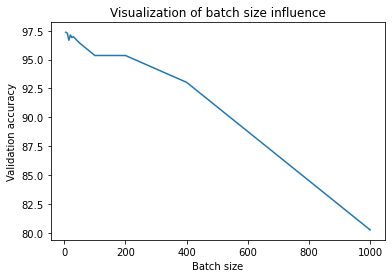

In [33]:
plt.plot(batch_size_set, val_accu_set)
plt.xlabel("Batch size")
plt.ylabel("Validation accuracy")
plt.title("Visualization of batch size influence")

#### Try different learning rate

In [439]:

lr_set = [0.001, 0.01, 0.1, 1, 10]
val_accu_set = []

In [440]:
for lrr in lr_set:
  model = Model()
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lrr)
  train(num_epochs, 25, criterion, optimizer, model, train_set)
  val_accu = accuracy(val_set, model)
  val_accu_set.append(val_accu)
  print("Current learning rate is: ", lrr, "; Validation accuracy is ", val_accu)

Current learning rate is:  0.001 ; Validation accuracy is  97.36638264910921
Current learning rate is:  0.01 ; Validation accuracy is  94.26800929512007
Current learning rate is:  0.1 ; Validation accuracy is  9.295120061967467
Current learning rate is:  1 ; Validation accuracy is  16.576297443841984
Current learning rate is:  10 ; Validation accuracy is  7.668474051123161


Text(0.5, 1.0, 'Visualization of learning rate influence')

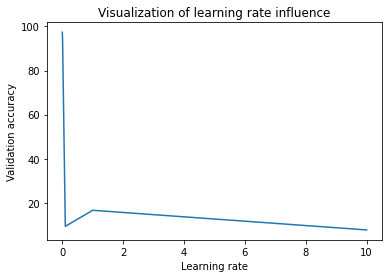

In [441]:
plt.plot(lr_set, val_accu_set)
plt.xlabel("Learning rate")
plt.ylabel("Validation accuracy")
plt.title("Visualization of learning rate influence")

#### Try different epochs

In [35]:
num_epochs_set = [10,20,30,50,80,100]
val_accu_set = []

In [43]:
for num_epochs in num_epochs_set:
  model = Model()
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  train(num_epochs, 25, criterion, optimizer, model, train_set)
  val_accu = accuracy(val_set, model)
  val_accu_set.append(val_accu)
  print("Current epochs is: ", num_epochs, "; Validation accuracy is ", val_accu)

Current epochs is:  10 ; Validation accuracy is  96.66924864446166
Current epochs is:  20 ; Validation accuracy is  97.83113865220758
Current epochs is:  30 ; Validation accuracy is  98.21843532145624
Current epochs is:  50 ; Validation accuracy is  98.14097598760651
Current epochs is:  80 ; Validation accuracy is  98.14097598760651
Current epochs is:  100 ; Validation accuracy is  97.2889233152595


In [46]:
val_accu_set.pop(0)

97.13400464756003

Text(0.5, 1.0, 'Visualization of epochs influence')

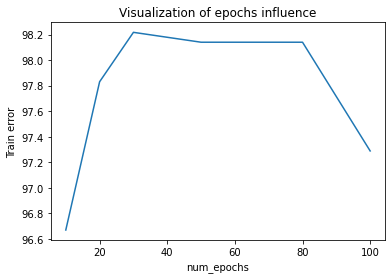

In [47]:
plt.plot(num_epochs_set, val_accu_set)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of epochs influence")

#### Try different optimizer

In [ ]:
optimizaer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-02, weight_decay=0, amsgrad=False)
train(num_epochs=10, batch_size, criterion, optimizer, model, train_set)
accuracy(val_set, model)


In [ ]:
optimizaer = 
train(num_epochs=10, batch_size, criterion, optimizer, model, train_set)
accuracy(val_set, model)

### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

In [120]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 30, 4)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(30, 150, 4)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.act2 = nn.ReLU()

        self.dropout = nn.Dropout(p = 0.01)
        
        
        self.fc1 = nn.Linear(150, 16)
        self.fc2 = nn.Linear(16, 10)
        
        self.output = nn.Softmax(dim=1)
     
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.pool2(x)
        x = self.act2(x)

        x = torch.flatten(x, 1)
    
        x = self.fc1(x)
        x = self.fc2(x)

        output = self.output(x)
        
        return output

In [121]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 20
batch_size = 50

# Use mean squared loss function 
criterion = nn.CrossEntropyLoss()

# Use SGD optimizer with a learning rate of 0.1
# It is initialized on our model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [122]:
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    
    for epoch in range(num_epochs):
        
        epoch_average_loss = 0.0
        
        for (images, labels) in train_loader:
            
            y_pre = model(images) 

            #labels = labels.float()
           
            loss = criterion(y_pre, labels)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            epoch_average_loss += loss.item() * batch_size / len(dataset)
            
        train_error.append(epoch_average_loss)
        #print('Epoch [{}/{}], Loss: {:.4f}'
                      #.format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

Text(0.5, 1.0, 'Visualization of convergence')

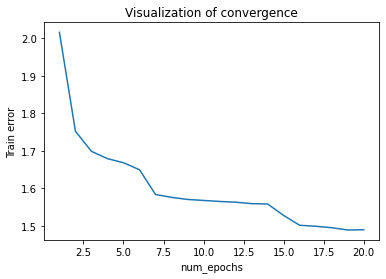

In [123]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

In [124]:
accuracy(val_set, model)

97.21146398140976

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [71]:
url = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.t.bz2'
r = requests.get(url, allow_redirects=True)
open('USPS/usps.t.bz2', 'wb').write(r.content)

1831726

In [125]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.USPS(root='USPS/',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=False)

In [126]:
accuracy(test_set, model)

93.22371699053313